In [1]:
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 27.7 MB/s eta 0:00:00


In [2]:
import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import librosa

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/daic/ProjectPrototype

/content/gdrive/MyDrive/daic/ProjectPrototype


In [5]:
!ls

'212148conf copy 3.ipynb'   edaicwoz   MFCCs_1030   MFCCs_1030.zip   preprocess_data.ipynb


In [6]:
train_labels_df = pd.read_csv("edaicwoz/train_split.csv")
test_labels_df = pd.read_csv("edaicwoz/test_split.csv")
val_labels_df = pd.read_csv("edaicwoz/dev_split.csv")

In [7]:
def load_audio_files(data_dir, sr=16000):
    file_ids = os.listdir(data_dir)
    subject_ids = []
    file_paths = []
    types = []
    labels = []
    labels_binary = []

    for file_id in file_ids:
        file_id = file_id.split("_")[0]
        file_path = [data_dir + "/" + file_id + "/" + file_id + "_MFCC_" + str(i) + ".npy" for i in range(len(next(iter(enumerate(os.walk(data_dir + "/" + str(file_id) + "/"))))[1][2]))]
        if int(file_id) in train_labels_df["Participant_ID"].values:
            types.append(0)
            labels.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])

        elif int(file_id) in test_labels_df["Participant_ID"].values:
            types.append(1)
            labels.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        else:
            types.append(2)
            labels.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        subject_ids.append(int(file_id))
        file_paths.append(file_path)

    return file_ids, subject_ids, file_paths, types, labels, labels_binary

data_dir = "MFCCs_1030"

file_ids, subject_ids, file_paths, types, labels, labels_binary = load_audio_files(data_dir)

In [8]:
def prepare_audio_set(file_paths):

    samples = []
    samples_ids = []
    samples_types = []
    samples_labels = []
    samples_labels_binary = []

    for i, file_path in enumerate(file_paths):
        all_mfccs = []
        for j in range(len(file_path)):
            all_mfccs.append(np.load(file_path[j]))
        all_mfccs = np.array(all_mfccs)
        samples.extend(all_mfccs)
        samples_ids.extend([subject_ids[i]] * len(all_mfccs))
        samples_types.extend([types[i]] * len(all_mfccs))
        samples_labels.extend([labels[i]] * len(all_mfccs))
        samples_labels_binary.extend([labels_binary[i]] * len(all_mfccs))

    samples = np.array(samples)

    samples_ids = np.array(samples_ids)
    samples_types = np.array(samples_types)
    samples_labels = np.array(samples_labels)
    samples_labels_binary = np.array(samples_labels_binary)

    return samples, samples_ids, samples_types, samples_labels, samples_labels_binary

print("[INFO] preparing data...")
samples, samples_ids, samples_types, samples_labels, samples_labels_binary = prepare_audio_set(file_paths)
samples = np.swapaxes(samples, 1, 2)

[INFO] preparing data...


In [9]:
training_samples = samples[samples_types == 0]
training_labels = samples_labels_binary[samples_types == 0]
training_subject_ids = samples_ids[samples_types == 0]

test_samples = samples[samples_types == 1]
test_labels = samples_labels_binary[samples_types == 1]

val_samples = samples[samples_types == 2]
val_labels_df = samples_labels_binary[samples_types == 2]

In [10]:
del samples, samples_ids, samples_types, samples_labels, samples_labels_binary
del file_ids, subject_ids, file_paths, types, labels, labels_binary

In [11]:
SEED = 42
NUM_CLIENTS = 8
BATCH_SIZE = 8
NUM_ROUNDS = 5
DEPRESSIVE_MULTIPLIER = 30
NON_DEPRESSIVE_MULTIPLIER = 10

In [12]:
def partition_data(X: np.ndarray, X_ids: np.ndarray, n_clients: int, d_mult: int, n_d_mult: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:

    unique_subject_ids, counts = np.unique(X_ids, return_counts=True)

    # grouping the training samples by patient
    training_samples_grouped = []
    for i in unique_subject_ids:
        training_samples_grouped.append(X[X_ids == i])
    training_samples_grouped = np.array(training_samples_grouped)

    mask_30_segments = np.array([sample.shape[0] == DEPRESSIVE_MULTIPLIER for sample in training_samples_grouped])

    # creating masks to get deppressives and non deppressives
    mask_10_segments = np.array([sample.shape[0] == NON_DEPRESSIVE_MULTIPLIER for sample in training_samples_grouped])

    data_array_30_segments = training_samples_grouped[mask_30_segments]

    data_array_10_segments = training_samples_grouped[mask_10_segments]

    # recreating labels
    X_train_zeros = np.array_split(data_array_10_segments, NUM_CLIENTS)
    X_train_ones = np.array_split(data_array_30_segments, NUM_CLIENTS)

    # concatenating splitted ones and zeros with labels
    X_train_splitted = [] # (NUM_CLIENTS, data)
    y_train_splitted = [] # (NUM_CLIENTS, labels)
    for i in range(NUM_CLIENTS):

        # stack the segments from groups then concatenate
        client_data = np.concatenate((np.vstack(X_train_zeros[i]), np.vstack(X_train_ones[i])), axis=0)
        client_labels = np.concatenate((np.zeros((X_train_zeros[i].shape[0] * NON_DEPRESSIVE_MULTIPLIER), dtype=int), np.ones((X_train_ones[i].shape[0] * DEPRESSIVE_MULTIPLIER), dtype=int)), axis=0)

        X_train_splitted.append(client_data)
        y_train_splitted.append(client_labels)

    return X_train_splitted, y_train_splitted

X_trains, y_trains = partition_data(training_samples, training_subject_ids, NUM_CLIENTS, DEPRESSIVE_MULTIPLIER, NON_DEPRESSIVE_MULTIPLIER)

<ipython-input-12-45e26c792d34>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_samples_grouped = np.array(training_samples_grouped)


In [ ]:
X_trains[0].shape

(610, 15001, 13)

In [14]:
def get_model(input_shape):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.GRU(units = 64, input_shape = input_shape))

    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [15]:
from flwr.common.typing import NDArrays
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model: tf.keras.models.Sequential, X_train: np.ndarray, y_train: np.ndarray):
        self.model = model

        self.X_train = X_train
        self.y_train = y_train


    def get_parameters(self, config):
        return self.model.get_weights()


    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> NDArrays:

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

        self.model.set_weights(parameters)

        history = self.model.fit(self.X_train, self.y_train ,batch_size=BATCH_SIZE, epochs=1, verbose=0)
        results = {
            "loss": history.history["loss"][0],
            "accuracy": history.history["accuracy"][0],
        }
        return self.model.get_weights(), len(self.X_train), results

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar])-> Tuple[float, int, Dict[str, Scalar]]:
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
        self.model.set_weights(parameters)

        loss, acc = self.model.evaluate(self.X_train, self.y_train, verbose=0)
        return loss, len(self.X_train), {"accuracy": acc}

In [16]:
# client creator by client id
def create_client_fn(cid: str) -> FlowerClient:

    input_shape = (15001, 13)
    model = get_model(input_shape)
    cid_int = int(cid)
    return FlowerClient(model, X_trains[cid_int], y_trains[cid_int])

In [17]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [18]:
patience = 5
best_accuracy = 0.0
best_loss = 999
weights = np.array([])

def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """Centralized evaluation function"""

    input_shape = (15001, 13)
    model = get_model(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

    model.set_weights(parameters)

    loss, accuracy = model.evaluate(val_samples, val_labels_df, batch_size=16, verbose=0)

    global best_accuracy
    global best_loss

    global weights
    print(f"LOSS: {loss}")
    print(f"BEST_LOSS: {best_loss}")
    print(f"ACCURACY: {accuracy}")
    print(f"BEST_ACCURACY: {best_accuracy}")

    if loss < best_loss:
        best_accuracy = accuracy
        weights = parameters
        best_loss = loss

    return loss, {"accuracy": accuracy}


client_resources = {"num_cpus": 2}
if tf.config.get_visible_devices("GPU"):
    client_resources["num_gpus"] = 1

# Specify the Strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  
    min_fit_clients=NUM_CLIENTS,  
    min_evaluate_clients=NUM_CLIENTS,  
    min_available_clients=NUM_CLIENTS,  # Wait until all 8 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=create_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=15),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-12-13 07:35:25,310 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-12-13 07:35:27,678	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-13 07:35:29,226 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 16280271667.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 32560543335.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 16280271667.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 32560543335.0}
INFO flwr 2023-12-13 07:35:29,229 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations

LOSS: 0.7099450826644897
BEST_LOSS: 999
ACCURACY: 0.550000011920929
BEST_ACCURACY: 0.0


DEBUG flwr 2023-12-13 07:38:55,838 | server.py:236 | fit_round 1 received 8 results and 0 failures
DEBUG:flwr:fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-12-13 07:38:55,853 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-12-13 07:39:05,435 | server.py:125 | fit progress: (1, 0.6778659224510193, {'accuracy': 0.5962499976158142}, 188.0163485930002)
INFO:flwr:fit progress: (1, 0.6778659224510193, {'accuracy': 0.5962499976158142}, 188.0163485930002)
DEBUG flwr 2023-12-13 07:39:05,440 | server.py:173 | evaluate_round 1: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 1: strategy sampled 8 clients (out of 8)


LOSS: 0.6778659224510193
BEST_LOSS: 0.7099450826644897
ACCURACY: 0.5962499976158142
BEST_ACCURACY: 0.550000011920929


DEBUG flwr 2023-12-13 07:40:30,771 | server.py:187 | evaluate_round 1 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 8 results and 0 failures
DEBUG flwr 2023-12-13 07:40:30,773 | server.py:222 | fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 07:43:21,560 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
INFO flwr 2023-12-13 07:43:31,088 | server.py:125 | fit progress: (2, 0.6760096549987793, {'accuracy': 0.5662500262260437}, 453.67018381900016)
INFO:flwr:fit progress: (2, 0.6760096549987793, {'accuracy': 0.5662500262260437}, 453.67018381900016)
DEBUG flwr 2023-12-13 07:43:31,090 | server.py:173 | evaluate_round 2: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 8 clients (out of 8)


LOSS: 0.6760096549987793
BEST_LOSS: 0.6778659224510193
ACCURACY: 0.5662500262260437
BEST_ACCURACY: 0.5962499976158142


DEBUG flwr 2023-12-13 07:44:54,207 | server.py:187 | evaluate_round 2 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 8 results and 0 failures
DEBUG flwr 2023-12-13 07:44:54,209 | server.py:222 | fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 07:47:46,717 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
INFO flwr 2023-12-13 07:47:56,258 | server.py:125 | fit progress: (3, 0.6721572279930115, {'accuracy': 0.574999988079071}, 718.8399257870001)
INFO:flwr:fit progress: (3, 0.6721572279930115, {'accuracy': 0.574999988079071}, 718.8399257870001)
DEBUG flwr 2023-12-13 07:47:56,261 | server.py:173 | evaluate_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 8 clients (out of 8)


LOSS: 0.6721572279930115
BEST_LOSS: 0.6760096549987793
ACCURACY: 0.574999988079071
BEST_ACCURACY: 0.5662500262260437


DEBUG flwr 2023-12-13 07:49:19,445 | server.py:187 | evaluate_round 3 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2023-12-13 07:49:19,448 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 07:52:10,280 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
INFO flwr 2023-12-13 07:52:19,777 | server.py:125 | fit progress: (4, 0.6656020283699036, {'accuracy': 0.6312500238418579}, 982.3592084000002)
INFO:flwr:fit progress: (4, 0.6656020283699036, {'accuracy': 0.6312500238418579}, 982.3592084000002)
DEBUG flwr 2023-12-13 07:52:19,780 | server.py:173 | evaluate_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 8 clients (out of 8)


LOSS: 0.6656020283699036
BEST_LOSS: 0.6721572279930115
ACCURACY: 0.6312500238418579
BEST_ACCURACY: 0.574999988079071


DEBUG flwr 2023-12-13 07:53:43,100 | server.py:187 | evaluate_round 4 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 8 results and 0 failures
DEBUG flwr 2023-12-13 07:53:43,106 | server.py:222 | fit_round 5: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 5: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 07:56:36,425 | server.py:236 | fit_round 5 received 8 results and 0 failures
DEBUG:flwr:fit_round 5 received 8 results and 0 failures
INFO flwr 2023-12-13 07:56:45,908 | server.py:125 | fit progress: (5, 0.6659483909606934, {'accuracy': 0.6575000286102295}, 1248.4894900560002)
INFO:flwr:fit progress: (5, 0.6659483909606934, {'accuracy': 0.6575000286102295}, 1248.4894900560002)
DEBUG flwr 2023-12-13 07:56:45,910 | server.py:173 | evaluate_round 5: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 5: strategy sampled 8 clients (out of 8)


LOSS: 0.6659483909606934
BEST_LOSS: 0.6656020283699036
ACCURACY: 0.6575000286102295
BEST_ACCURACY: 0.6312500238418579


DEBUG flwr 2023-12-13 07:58:09,343 | server.py:187 | evaluate_round 5 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 8 results and 0 failures
DEBUG flwr 2023-12-13 07:58:09,346 | server.py:222 | fit_round 6: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 6: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:01:01,065 | server.py:236 | fit_round 6 received 8 results and 0 failures
DEBUG:flwr:fit_round 6 received 8 results and 0 failures
INFO flwr 2023-12-13 08:01:10,584 | server.py:125 | fit progress: (6, 0.6650763750076294, {'accuracy': 0.6387500166893005}, 1513.165479829)
INFO:flwr:fit progress: (6, 0.6650763750076294, {'accuracy': 0.6387500166893005}, 1513.165479829)
DEBUG flwr 2023-12-13 08:01:10,586 | server.py:173 | evaluate_round 6: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 6: strategy sampled 8 clients (out of 8)


LOSS: 0.6650763750076294
BEST_LOSS: 0.6656020283699036
ACCURACY: 0.6387500166893005
BEST_ACCURACY: 0.6312500238418579


DEBUG flwr 2023-12-13 08:02:34,310 | server.py:187 | evaluate_round 6 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:02:34,313 | server.py:222 | fit_round 7: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 7: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:05:28,362 | server.py:236 | fit_round 7 received 8 results and 0 failures
DEBUG:flwr:fit_round 7 received 8 results and 0 failures
INFO flwr 2023-12-13 08:05:37,856 | server.py:125 | fit progress: (7, 0.6588788628578186, {'accuracy': 0.6474999785423279}, 1780.4379944500001)
INFO:flwr:fit progress: (7, 0.6588788628578186, {'accuracy': 0.6474999785423279}, 1780.4379944500001)
DEBUG flwr 2023-12-13 08:05:37,861 | server.py:173 | evaluate_round 7: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 7: strategy sampled 8 clients (out of 8)


LOSS: 0.6588788628578186
BEST_LOSS: 0.6650763750076294
ACCURACY: 0.6474999785423279
BEST_ACCURACY: 0.6387500166893005


DEBUG flwr 2023-12-13 08:07:01,637 | server.py:187 | evaluate_round 7 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:07:01,642 | server.py:222 | fit_round 8: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 8: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:09:53,720 | server.py:236 | fit_round 8 received 8 results and 0 failures
DEBUG:flwr:fit_round 8 received 8 results and 0 failures
INFO flwr 2023-12-13 08:10:03,151 | server.py:125 | fit progress: (8, 0.6568055748939514, {'accuracy': 0.6025000214576721}, 2045.732338188)
INFO:flwr:fit progress: (8, 0.6568055748939514, {'accuracy': 0.6025000214576721}, 2045.732338188)
DEBUG flwr 2023-12-13 08:10:03,153 | server.py:173 | evaluate_round 8: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 8: strategy sampled 8 clients (out of 8)


LOSS: 0.6568055748939514
BEST_LOSS: 0.6588788628578186
ACCURACY: 0.6025000214576721
BEST_ACCURACY: 0.6474999785423279


DEBUG flwr 2023-12-13 08:11:27,256 | server.py:187 | evaluate_round 8 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:11:27,260 | server.py:222 | fit_round 9: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 9: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:14:22,358 | server.py:236 | fit_round 9 received 8 results and 0 failures
DEBUG:flwr:fit_round 9 received 8 results and 0 failures
INFO flwr 2023-12-13 08:14:31,881 | server.py:125 | fit progress: (9, 0.6629763245582581, {'accuracy': 0.59375}, 2314.463162329)
INFO:flwr:fit progress: (9, 0.6629763245582581, {'accuracy': 0.59375}, 2314.463162329)
DEBUG flwr 2023-12-13 08:14:31,883 | server.py:173 | evaluate_round 9: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 9: strategy sampled 8 clients (out of 8)


LOSS: 0.6629763245582581
BEST_LOSS: 0.6568055748939514
ACCURACY: 0.59375
BEST_ACCURACY: 0.6025000214576721


DEBUG flwr 2023-12-13 08:15:56,074 | server.py:187 | evaluate_round 9 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:15:56,079 | server.py:222 | fit_round 10: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 10: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:18:48,636 | server.py:236 | fit_round 10 received 8 results and 0 failures
DEBUG:flwr:fit_round 10 received 8 results and 0 failures
INFO flwr 2023-12-13 08:18:58,110 | server.py:125 | fit progress: (10, 0.6657003164291382, {'accuracy': 0.5787500143051147}, 2580.6922694990003)
INFO:flwr:fit progress: (10, 0.6657003164291382, {'accuracy': 0.5787500143051147}, 2580.6922694990003)
DEBUG flwr 2023-12-13 08:18:58,113 | server.py:173 | evaluate_round 10: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 10: strategy sampled 8 clients (out of 8)


LOSS: 0.6657003164291382
BEST_LOSS: 0.6568055748939514
ACCURACY: 0.5787500143051147
BEST_ACCURACY: 0.6025000214576721


DEBUG flwr 2023-12-13 08:20:22,575 | server.py:187 | evaluate_round 10 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:20:22,582 | server.py:222 | fit_round 11: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 11: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:23:19,074 | server.py:236 | fit_round 11 received 8 results and 0 failures
DEBUG:flwr:fit_round 11 received 8 results and 0 failures
INFO flwr 2023-12-13 08:23:28,597 | server.py:125 | fit progress: (11, 0.667773962020874, {'accuracy': 0.5912500023841858}, 2851.1791510539997)
INFO:flwr:fit progress: (11, 0.667773962020874, {'accuracy': 0.5912500023841858}, 2851.1791510539997)
DEBUG flwr 2023-12-13 08:23:28,599 | server.py:173 | evaluate_round 11: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 11: strategy sampled 8 clients (out of 8)


LOSS: 0.667773962020874
BEST_LOSS: 0.6568055748939514
ACCURACY: 0.5912500023841858
BEST_ACCURACY: 0.6025000214576721


DEBUG flwr 2023-12-13 08:24:53,174 | server.py:187 | evaluate_round 11 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:24:53,176 | server.py:222 | fit_round 12: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 12: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:27:45,931 | server.py:236 | fit_round 12 received 8 results and 0 failures
DEBUG:flwr:fit_round 12 received 8 results and 0 failures
INFO flwr 2023-12-13 08:27:55,473 | server.py:125 | fit progress: (12, 0.6663548946380615, {'accuracy': 0.5699999928474426}, 3118.054564512)
INFO:flwr:fit progress: (12, 0.6663548946380615, {'accuracy': 0.5699999928474426}, 3118.054564512)
DEBUG flwr 2023-12-13 08:27:55,475 | server.py:173 | evaluate_round 12: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 12: strategy sampled 8 clients (out of 8)


LOSS: 0.6663548946380615
BEST_LOSS: 0.6568055748939514
ACCURACY: 0.5699999928474426
BEST_ACCURACY: 0.6025000214576721


DEBUG flwr 2023-12-13 08:29:19,988 | server.py:187 | evaluate_round 12 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:29:19,991 | server.py:222 | fit_round 13: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 13: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:32:17,094 | server.py:236 | fit_round 13 received 8 results and 0 failures
DEBUG:flwr:fit_round 13 received 8 results and 0 failures
INFO flwr 2023-12-13 08:32:26,608 | server.py:125 | fit progress: (13, 0.6671948432922363, {'accuracy': 0.5862500071525574}, 3389.1897549800005)
INFO:flwr:fit progress: (13, 0.6671948432922363, {'accuracy': 0.5862500071525574}, 3389.1897549800005)
DEBUG flwr 2023-12-13 08:32:26,610 | server.py:173 | evaluate_round 13: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 13: strategy sampled 8 clients (out of 8)


LOSS: 0.6671948432922363
BEST_LOSS: 0.6568055748939514
ACCURACY: 0.5862500071525574
BEST_ACCURACY: 0.6025000214576721


DEBUG flwr 2023-12-13 08:33:51,075 | server.py:187 | evaluate_round 13 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:33:51,084 | server.py:222 | fit_round 14: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 14: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:36:44,132 | server.py:236 | fit_round 14 received 8 results and 0 failures
DEBUG:flwr:fit_round 14 received 8 results and 0 failures
INFO flwr 2023-12-13 08:36:53,525 | server.py:125 | fit progress: (14, 0.6640973687171936, {'accuracy': 0.6025000214576721}, 3656.106338251)
INFO:flwr:fit progress: (14, 0.6640973687171936, {'accuracy': 0.6025000214576721}, 3656.106338251)
DEBUG flwr 2023-12-13 08:36:53,527 | server.py:173 | evaluate_round 14: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 14: strategy sampled 8 clients (out of 8)


LOSS: 0.6640973687171936
BEST_LOSS: 0.6568055748939514
ACCURACY: 0.6025000214576721
BEST_ACCURACY: 0.6025000214576721


DEBUG flwr 2023-12-13 08:38:18,296 | server.py:187 | evaluate_round 14 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 8 results and 0 failures
DEBUG flwr 2023-12-13 08:38:18,300 | server.py:222 | fit_round 15: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 15: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-12-13 08:41:16,585 | server.py:236 | fit_round 15 received 8 results and 0 failures
DEBUG:flwr:fit_round 15 received 8 results and 0 failures
INFO flwr 2023-12-13 08:41:26,129 | server.py:125 | fit progress: (15, 0.6688230633735657, {'accuracy': 0.5987499952316284}, 3928.71058179)
INFO:flwr:fit progress: (15, 0.6688230633735657, {'accuracy': 0.5987499952316284}, 3928.71058179)
DEBUG flwr 2023-12-13 08:41:26,131 | server.py:173 | evaluate_round 15: strategy sampled 8 clients (out of 8)
DEBUG:flwr:evaluate_round 15: strategy sampled 8 clients (out of 8)


LOSS: 0.6688230633735657
BEST_LOSS: 0.6568055748939514
ACCURACY: 0.5987499952316284
BEST_ACCURACY: 0.6025000214576721


DEBUG flwr 2023-12-13 08:42:51,342 | server.py:187 | evaluate_round 15 received 8 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 8 results and 0 failures
INFO flwr 2023-12-13 08:42:51,346 | server.py:153 | FL finished in 4013.928286485
INFO:flwr:FL finished in 4013.928286485
INFO flwr 2023-12-13 08:42:51,361 | app.py:226 | app_fit: losses_distributed [(1, 0.6966565743405768), (2, 0.691108407111878), (3, 0.6872545216945891), (4, 0.6833108612831603), (5, 0.6778410008613099), (6, 0.6726266158388016), (7, 0.6690515023596744), (8, 0.660135530410929), (9, 0.6555818611002983), (10, 0.6505945454252527), (11, 0.6458311162096388), (12, 0.6379370539746386), (13, 0.6357765699954743), (14, 0.6323376526223853), (15, 0.6295694262423414)]
INFO:flwr:app_fit: losses_distributed [(1, 0.6966565743405768), (2, 0.691108407111878), (3, 0.6872545216945891), (4, 0.6833108612831603), (5, 0.6778410008613099), (6, 0.6726266158388016), (7, 0.6690515023596744), (8, 0.660135530410929), (9, 0.6555818611

In [19]:
history

History (loss, distributed):
	round 1: 0.6966565743405768
	round 2: 0.691108407111878
	round 3: 0.6872545216945891
	round 4: 0.6833108612831603
	round 5: 0.6778410008613099
	round 6: 0.6726266158388016
	round 7: 0.6690515023596744
	round 8: 0.660135530410929
	round 9: 0.6555818611002983
	round 10: 0.6505945454252527
	round 11: 0.6458311162096388
	round 12: 0.6379370539746386
	round 13: 0.6357765699954743
	round 14: 0.6323376526223853
	round 15: 0.6295694262423414
History (loss, centralized):
	round 0: 0.7099450826644897
	round 1: 0.6778659224510193
	round 2: 0.6760096549987793
	round 3: 0.6721572279930115
	round 4: 0.6656020283699036
	round 5: 0.6659483909606934
	round 6: 0.6650763750076294
	round 7: 0.6588788628578186
	round 8: 0.6568055748939514
	round 9: 0.6629763245582581
	round 10: 0.6657003164291382
	round 11: 0.667773962020874
	round 12: 0.6663548946380615
	round 13: 0.6671948432922363
	round 14: 0.6640973687171936
	round 15: 0.6688230633735657
History (metrics, distributed, eva

In [20]:
# printing validation results
print(best_accuracy)
print(best_loss)
print(patience)
print(weights)

0.6025000214576721
0.6568055748939514
5
[array([[-0.13460515,  0.06228058,  0.03838665, ...,  0.17535798,
         0.04479178, -0.01715418],
       [ 0.00203934,  0.10265492,  0.14164227, ..., -0.016276  ,
        -0.11732892,  0.10386518],
       [ 0.02977264, -0.0011257 ,  0.16838941, ..., -0.06271558,
         0.03566251, -0.08439081],
       ...,
       [-0.03657882, -0.09460166, -0.15420623, ...,  0.01238968,
         0.12772027, -0.10711696],
       [-0.10489268, -0.05170003,  0.03282207, ..., -0.01650331,
         0.08906396, -0.02811069],
       [-0.00391807, -0.10726549,  0.13712958, ..., -0.11617575,
        -0.11922924, -0.17400593]], dtype=float32), array([[ 0.00230269,  0.05059732, -0.06124302, ..., -0.06548548,
         0.01021009, -0.03047876],
       [ 0.01288502, -0.06277417,  0.0346423 , ...,  0.08471325,
         0.041029  , -0.03413061],
       [ 0.0948083 , -0.01296777,  0.06131935, ...,  0.14463829,
        -0.03283406,  0.01855972],
       ...,
       [ 0.0370817

In [21]:
# test results
input_shape = (15001, 13)
test_model = get_model(input_shape)
test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
test_model.set_weights(weights)
print("[INFO] evaluating on testing set...")
(test_loss, test_accuracy) = test_model.evaluate(test_samples, test_labels, batch_size=8, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(test_loss, test_accuracy * 100))

[INFO] evaluating on testing set...
70/70 [==============================] - 11s 146ms/step - loss: 0.6967 - accuracy: 0.5268
[INFO] loss=0.6967, accuracy: 52.6786%


In [22]:
from tqdm import tqdm

test_preds = []

file_ids = os.listdir(data_dir)
test_label_file = pd.read_csv("edaicwoz/test_split.csv")

for file_id in tqdm(file_ids):
    if int(file_id) in test_label_file["Participant_ID"].values:
        all_mfccs = []
        for j in range(10):
            file_path = "MFCCs_1030/" + file_id + "/" + file_id + "_MFCC_" + str(j) + ".npy"
            all_mfccs.append(np.load(file_path))
        all_mfccs = np.array(all_mfccs)
        all_mfccs = np.swapaxes(all_mfccs, 1, 2)
        prediction = test_model.predict(all_mfccs, verbose=0, batch_size=8)
        prediction = prediction.mean(axis=0)
        test_preds.append(prediction)

100%|██████████| 273/273 [00:21<00:00, 12.68it/s]


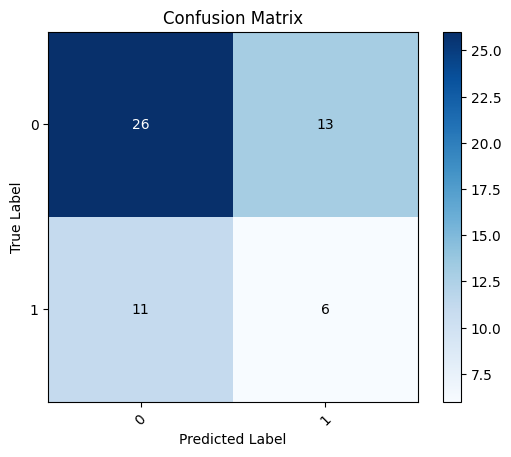

              precision    recall  f1-score   support

           0       0.70      0.67      0.68        39
           1       0.32      0.35      0.33        17

    accuracy                           0.57        56
   macro avg       0.51      0.51      0.51        56
weighted avg       0.59      0.57      0.58        56



In [23]:
label_file = test_label_file
true = label_file.to_numpy()[:, 2].flatten().tolist()
predicted = (np.array(test_preds) > 0.5).astype(np.int32).flatten().tolist()



true_labels = true
predicted_labels = predicted

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def create_confusion_matrix(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

def plot_confusion_matrix(conf_matrix, classes):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return precision, recall, f1

conf_matrix = create_confusion_matrix(true_labels, predicted_labels)
classes = ['0', '1']

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, classes)

# Calculate precision, recall, and F1-score

# Calculate precision, recall, and F1-score for both classes
classification_report = classification_report(true_labels, predicted_labels, target_names=classes)

print(classification_report)